# Modified Swiss Dwellings

In [1]:
from pathlib import Path
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from utils.utils import load_yaml_config

cfg = load_yaml_config()
datasets_cfg = cfg["file_paths"]["datasets"]
DATASETS_DIR = datasets_cfg["root"]
datasets = Path(DATASETS_DIR)

msd = datasets / datasets_cfg["relative_paths"]["modified_swiss_dwellings"]

assert msd.is_dir, f"Invalid directory: {msd}"
msd

PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/Modified Swiss Dwellings/archive')

In [8]:
import pandas as pd

csv_file = [f for f in msd.iterdir() if f.suffix == ".csv"].pop()
print(f"CSV file: {csv_file.name}")

df = pd.read_csv(csv_file)

# Drop the first two columns
df = df.iloc[:, 2:]

df.head()

CSV file: mds_V2_5.372k.csv


,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geom,elevation,height,zoning,roomtype
0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6,Zone3,Bathroom
1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6,Zone2,Livingroom
2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6,Zone1,Bedroom
3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6,Zone2,Kitchen
4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6,Zone1,Bedroom


In [13]:
splits = [split for split in [f for f in msd.iterdir() if not f.suffix].pop().iterdir()]
splits

[PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/Modified Swiss Dwellings/archive/modified-swiss-dwellings-v2/test'),
 PosixPath('/home/yunusskeete/Documents/data/2D/Floor Plans/Modified Swiss Dwellings/archive/modified-swiss-dwellings-v2/train')]

In [20]:
test_split, train_split = splits
test_split_paths_dict = {f.name: f for f in test_split.iterdir()}
train_split_paths_dict = {f.name: f for f in train_split.iterdir()}
train_split_paths_dict.keys()

dict_keys(['graph_in', 'graph_out', 'full_out', 'struct_in'])

In [31]:
import random

N = 5
all_files = [f for f in train_split_paths_dict["struct_in"].iterdir()]
assert N <= sum(1 for item in all_files if item.is_file())

random_files = random.sample(all_files, N)
[f.name for f in random_files[:5]]

['10782.npy', '468.npy', '45790.npy', '13662.npy', '7411.npy']

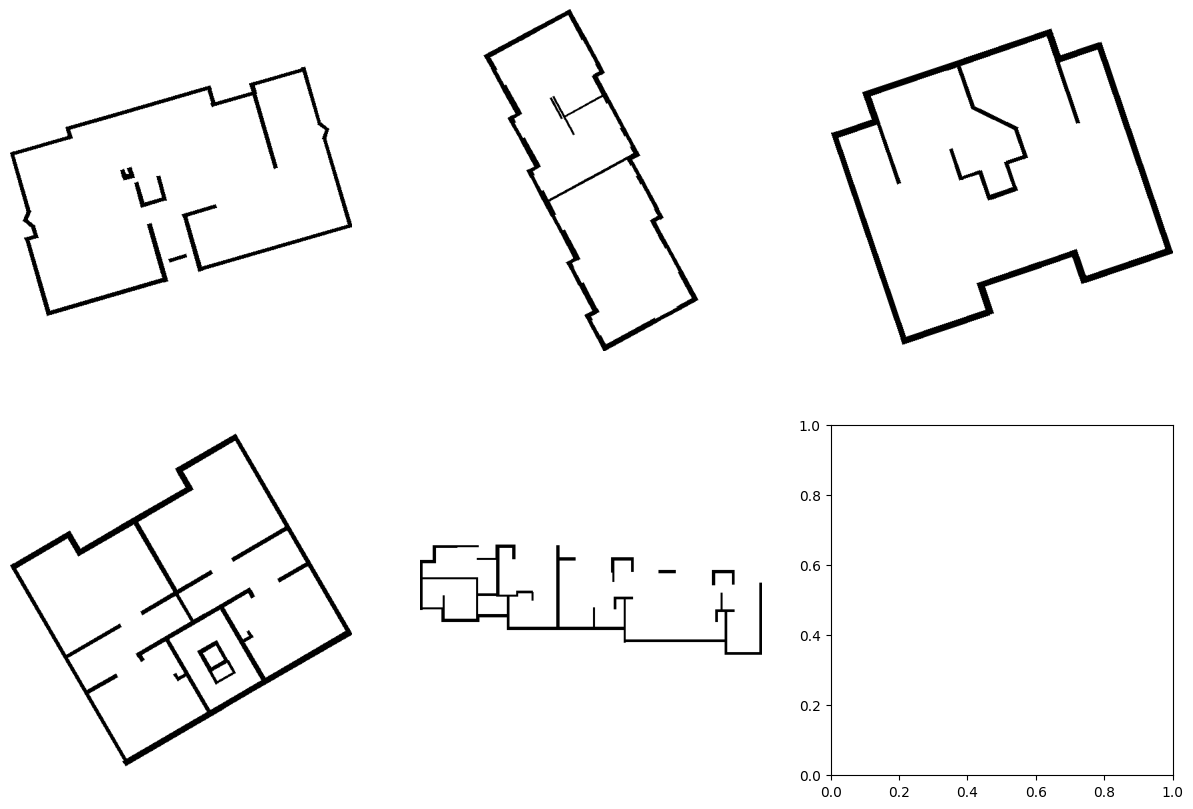

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# set up figure
figures = min(N, 10)
rows = 2
fig, axs = plt.subplots(
    rows,
    min(figures // rows + 1, figures / rows + 1),
    figsize=(figures * min(figures // rows + 1, figures / rows + 1), figures * rows),
)
axs = axs.flatten()

for idx, random_file in enumerate(random_files):
    # set axis
    ax = axs[idx]
    _ = [ax.axis("off"), ax.axes.set_aspect("equal")]

    # get structural components
    stack = np.load(random_file)

    # channel 1: structural components
    # note: channel 2 and 3 are x and y locations
    #   this holds for "full_out" as well
    struct = stack[..., 0].astype(np.uint8)
    ax.imshow(struct, cmap="gray")

In [74]:
from constants import ROOM_NAMES, CMAP_ROOMTYPE

class_mapping = {cat: index for index, cat in enumerate(ROOM_NAMES)}
CLASSES = list(map(class_mapping.get, ROOM_NAMES))


# helper function to colorize floor plan
def colorize_floorplan(img, classes, cmap):
    """
    Colorizes an integer-valued image (multi-class segmentation mask)
    based on a pre-defined cmap colorset.
    """

    h, w = np.shape(img)
    img_c = (np.ones((h, w, 3)) * 255).astype(int)
    for cat in classes:
        color = np.array(cmap(cat))[:3] * 255
        # print(color)
        img_c[img == cat, :] = (color).astype(int)

    # print(img_c)
    return img_c

In [75]:
class_mapping

{'Bedroom': 0,
 'Livingroom': 1,
 'Kitchen': 2,
 'Dining': 3,
 'Corridor': 4,
 'Stairs': 5,
 'Storeroom': 6,
 'Bathroom': 7,
 'Balcony': 8,
 'Structure': 9,
 'Door': 10,
 'Entrance Door': 11,
 'Window': 12}

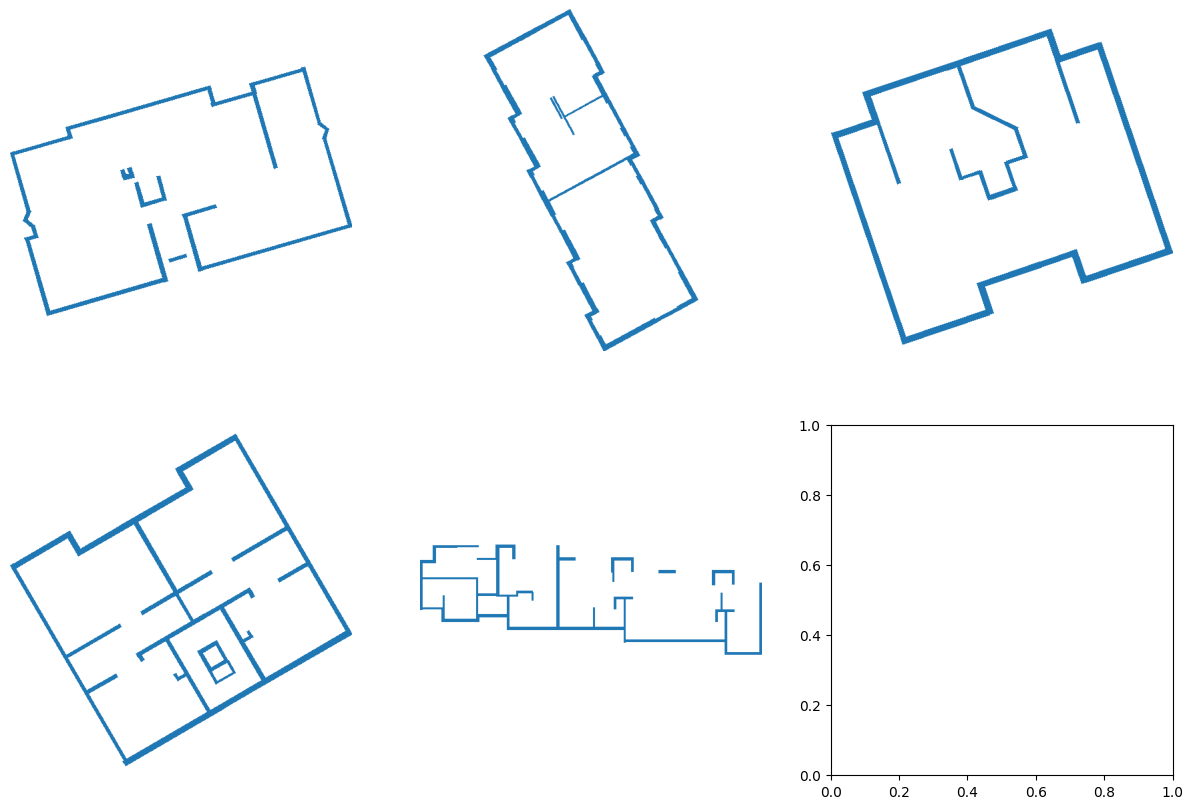

In [76]:
# set up figure
figures = min(N, 10)
rows = 2
fig, axs = plt.subplots(
    rows,
    min(figures // rows + 1, figures / rows + 1),
    figsize=(figures * min(figures // rows + 1, figures / rows + 1), figures * rows),
)
axs = axs.flatten()

for idx, random_file in enumerate(random_files):
    # set axis
    ax = axs[idx]
    _ = [ax.axis("off"), ax.axes.set_aspect("equal")]

    # get structural components
    stack = np.load(random_file)

    # channel 1: structural components
    # note: channel 2 and 3 are x and y locations
    #   this holds for "full_out" as well
    img = stack[..., 0].astype(np.uint8)
    ax.imshow(colorize_floorplan(img, classes=CLASSES, cmap=CMAP_ROOMTYPE))